<a href="https://colab.research.google.com/github/Daeun-Danna-Lee/NLP-Sentiment-Classification/blob/main/Movie_Review_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이다은/2019312492/0.828

### 개발 환경

- 애플 실리콘(M1) 맥북
- macOS Big Sur 12.0.1
- python 3.7.12
- google colab

In [ ]:
import sys

print(sys.version)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [1]:
!pip install konlpy
!pip install tensorflow
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install kobert

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 448 kB 37.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 46.9 MB 1.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.3 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595721 sha256=54b8bdfe6e542b65a01aaa5f7160723ad172aa773886ae82b18a7bf108824a0e
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.4 MB/s 
     |█

In [2]:
pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-a8lqfvq1
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-a8lqfvq1
     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 29.0 MB/s 
     |████████████████████████████████| 61 kB 519 kB/s 
     |████████████████████████████████| 3.3 MB 39.1 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=13136 sha256=a54a890f0087be73fa593ea17e53f65dd0114348cfcc3215d35d6411ca370f51
  Stored in directory: /tmp/pip-ephem-wheel-cache-78j26qb2/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tokenizers
    Found existi

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#GPU 사용
device = torch.device("cuda:0")

In [7]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

.cache/kobert_v1.zip[██████████████████████████████████████████████████]
.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [8]:
# 데이터 불러오기

data = pd.read_csv('./purified_data', sep=',', names=['Sentence', 'Emotion'])
data

,Sentence,Emotion
0,"어, 청소 니가 대신 해 줘!",4
1,둘 다 청소 하기 싫어. 귀찮아.,4
2,둘 다 하기 싫어서 화내.,1
3,그럼 방세는 어떡해.,5
4,권태긴줄 알았는데 다른 사람이 생겼나보더라고.,5
...,...,...
138207,얘긴 다 끝났냐? 원예부,4
138208,"예. 그거 때문에, 부탁이 있......는......데요.",4
138209,여자 숨겨달라는거면 사절이다.,4
138210,아무래도 안되나요?,4


In [9]:
# 구둣점 제거 -> 공백으로 대체
data['Sentence'] = data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]"," ")

In [10]:
data

,Sentence,Emotion
0,어 청소 니가 대신 해 줘,4
1,둘 다 청소 하기 싫어 귀찮아,4
2,둘 다 하기 싫어서 화내,1
3,그럼 방세는 어떡해,5
4,권태긴줄 알았는데 다른 사람이 생겼나보더라고,5
...,...,...
138207,얘긴 다 끝났냐 원예부,4
138208,예 그거 때문에 부탁이 있 는 데요,4
138209,여자 숨겨달라는거면 사절이다,4
138210,아무래도 안되나요,4


In [11]:
data_list = []
for q, label in zip(data['Sentence'], data['Emotion']):
    temp = []
    temp.append(q)
    temp.append(str(label))

    data_list.append(temp)

In [12]:
# train, test data 분리

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_list, test_size = 0.2)

In [13]:
print(len(train_df))
print(len(test_df))

110569
27643


In [14]:
# stopwords 정의 (https://www.ranks.nl/stopwords/korean)

stopwords = ['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로', '바꾸어서 말하면', '바꾸어서 한다면', '만약', '그렇지않으면', '까악', '툭', '딱', '삐걱거리다', '보드득', '비걱거리다', '꽈당', '응당', '해야한다', '에 가서', '각', '각각', '여러분', '각종', '각자', '제각기', '하도록하다', '와', '과', '그러므로', '그래서', '고로', '한 까닭에', '하기 때문에', '거니와', '이지만', '대하여', '관하여', '관한', '과연', '실로', '아니나다를가', '생각한대로', '진짜로', '한적이있다', '하곤하였다', '하', '하하', '허허', '아하', '거바', '와', '오', '왜', '어째서', '무엇때문에', '어찌', '하겠는가', '무슨', '어디', '어느곳', '더군다나', '하물며', '더욱이는', '어느때', '언제', '야', '이봐', '어이', '여보시오', '흐흐', '흥', '휴', '헉헉', '헐떡헐떡', '영차', '여차', '어기여차', '끙끙', '아야', '앗', '아야', '콸콸', '졸졸', '좍좍', '뚝뚝', '주룩주룩', '솨', '우르르', '그래도', '또', '그리고', '바꾸어말하면', '바꾸어말하자면', '혹은', '혹시', '답다', '및', '그에 따르는', '때가 되어', '즉', '지든지', '설령', '가령', '하더라도', '할지라도', '일지라도', '지든지', '몇', '거의', '하마터면', '인젠', '이젠', '된바에야', '된이상', '만큼어찌됏든', '그위에', '게다가', '점에서 보아', '비추어 보아', '고려하면', '하게될것이다', '일것이다', '비교적', '좀', '보다더', '비하면', '시키다', '하게하다', '할만하다', '의해서', '연이서', '이어서', '잇따라', '뒤따라', '뒤이어', '결국', '의지하여', '기대여', '통하여', '자마자', '더욱더', '불구하고', '얼마든지', '마음대로', '주저하지 않고', '곧', '즉시', '바로', '당장', '하자마자', '밖에 안된다', '하면된다', '그래', '그렇지', '요컨대', '다시 말하자면', '바꿔 말하면', '즉', '구체적으로', '말하자면', '시작하여', '시초에', '이상', '허', '헉', '허걱', '바와같이', '해도좋다', '해도된다', '게다가', '더구나', '하물며', '와르르', '팍', '퍽', '펄렁', '동안', '이래', '하고있었다', '이었다', '에서', '로부터', '까지', '예하면', '했어요', '해요', '함께', '같이', '더불어', '마저', '마저도', '양자', '모두', '습니다', '가까스로', '하려고하다', '즈음하여', '다른', '다른 방면으로', '해봐요', '습니까', '했어요', '말할것도 없고', '무릎쓰고', '개의치않고', '하는것만 못하다', '하는것이 낫다', '매', '매번', '들', '모', '어느것', '어느', '로써', '갖고말하자면', '어디', '어느쪽', '어느것', '어느해', '어느 년도', '라 해도', '언젠가', '어떤것', '어느것', '저기', '저쪽', '저것', '그때', '그럼', '그러면', '요만한걸', '그래', '그때', '저것만큼', '그저', '이르기까지', '할 줄 안다', '할 힘이 있다', '너', '너희', '당신', '어찌', '설마', '차라리', '할지언정', '할지라도', '할망정', '할지언정', '구토하다', '게우다', '토하다', '메쓰겁다', '옆사람', '퉤', '쳇', '의거하여', '근거하여', '의해', '따라', '힘입어', '그', '다음', '버금', '두번째로', '기타', '첫번째로', '나머지는', '그중에서', '견지에서', '형식으로 쓰여', '입장에서', '위해서', '단지', '의해되다', '하도록시키다', '뿐만아니라', '반대로', '전후', '전자', '앞의것', '잠시', '잠깐', '하면서', '그렇지만', '다음에', '그러한즉', '그런즉', '남들', '아무거나', '어찌하든지', '같다', '비슷하다', '예컨대', '이럴정도로', '어떻게', '만약', '만일', '위에서 서술한바와같이', '인 듯하다', '하지 않는다면', '만약에', '무엇', '무슨', '어느', '어떤', '아래윗', '조차', '한데', '그럼에도 불구하고', '여전히', '심지어', '까지도', '조차도', '하지 않도록', '않기 위하여', '때', '시각', '무렵', '시간', '동안', '어때', '어떠한', '하여금', '네', '예', '우선', '누구', '누가 알겠는가', '아무도', '줄은모른다', '줄은 몰랏다', '하는 김에', '겸사겸사', '하는바', '그런 까닭에', '한 이유는', '그러니', '그러니까', '때문에', '그', '너희', '그들', '너희들', '타인', '것', '것들', '너', '위하여', '공동으로', '동시에', '하기 위하여', '어찌하여', '무엇때문에', '붕붕', '윙윙', '나', '우리', '엉엉', '휘익', '윙윙', '오호', '아하', '어쨋든', '만 못하다하기보다는', '차라리', '하는 편이 낫다', '흐흐', '놀라다', '상대적으로 말하자면', '마치', '아니라면', '쉿', '그렇지 않으면', '그렇지 않다면', '안 그러면', '아니었다면', '하든지', '아니면', '이라면', '좋아', '알았어', '하는것도', '그만이다', '어쩔수 없다', '하나', '일', '일반적으로', '일단', '한켠으로는', '오자마자', '이렇게되면', '이와같다면', '전부', '한마디', '한항목', '근거로', '하기에', '아울러', '하지 않도록', '않기 위해서', '이르기까지', '이 되다', '로 인하여', '까닭으로', '이유만으로', '이로 인하여', '그래서', '이 때문에', '그러므로', '그런 까닭에', '알 수 있다', '결론을 낼 수 있다', '으로 인하여', '있다', '어떤것', '관계가 있다', '관련이 있다', '연관되다', '어떤것들', '에 대해', '이리하여', '그리하여', '여부', '하기보다는', '하느니', '하면 할수록', '운운', '이러이러하다', '하구나', '하도다', '다시말하면', '다음으로', '에 있다', '에 달려 있다', '우리', '우리들', '오히려', '하기는한데', '어떻게', '어떻해', '어찌됏어', '어때', '어째서', '본대로', '자', '이', '이쪽', '여기', '이것', '이번', '이렇게말하자면', '이런', '이러한', '이와 같은', '요만큼', '요만한 것', '얼마 안 되는 것', '이만큼', '이 정도의', '이렇게 많은 것', '이와 같다', '이때', '이렇구나', '것과 같이', '끼익', '삐걱', '따위', '와 같은 사람들', '부류의 사람들', '왜냐하면', '중의하나', '오직', '오로지', '에 한하다', '하기만 하면', '도착하다', '까지 미치다', '도달하다', '정도에 이르다', '할 지경이다', '결과에 이르다', '관해서는', '여러분', '하고 있다', '한 후', '혼자', '자기', '자기집', '자신', '우에 종합한것과같이', '총적으로 보면', '총적으로 말하면', '총적으로', '대로 하다', '으로서', '참', '그만이다', '할 따름이다', '쿵', '탕탕', '쾅쾅', '둥둥', '봐', '봐라', '아이야', '아니', '와아', '응', '아이', '참나', '년', '월', '일', '령', '영', '일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '이천육', '이천칠', '이천팔', '이천구', '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '령', '영']


In [15]:
# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [16]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [17]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [18]:
data_train = BERTDataset(train_df, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test_df, 0, 1, tok, max_len, True, False)

In [19]:
data_train[0]

(array([   2, 2266, 2010, 5570, 3059,    3,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(6, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 5)

In [20]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [22]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [23]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [24]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [25]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [26]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [27]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [28]:
train_dataloader

In [29]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1728 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.0469467639923096 train acc 0.1875
epoch 1 batch id 201 loss 1.6038050651550293 train acc 0.3599968905472637
epoch 1 batch id 401 loss 1.1233406066894531 train acc 0.43309694513715713
epoch 1 batch id 601 loss 1.2956792116165161 train acc 0.4762635191347754
epoch 1 batch id 801 loss 1.3795344829559326 train acc 0.5031796192259675
epoch 1 batch id 1001 loss 1.060038447380066 train acc 0.5247408841158842
epoch 1 batch id 1201 loss 0.9010116457939148 train acc 0.5411506036636137
epoch 1 batch id 1401 loss 0.9585493803024292 train acc 0.5538343147751607
epoch 1 batch id 1601 loss 1.0300707817077637 train acc 0.564510462211118
epoch 1 train acc 0.5699159644591237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/432 [00:00<?, ?it/s]

epoch 1 test acc 0.664296678829253


  0%|          | 0/1728 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9684479832649231 train acc 0.71875
epoch 2 batch id 201 loss 0.9721839427947998 train acc 0.6411691542288557
epoch 2 batch id 401 loss 0.8497517704963684 train acc 0.6548082917705735
epoch 2 batch id 601 loss 1.0193898677825928 train acc 0.6576539101497504
epoch 2 batch id 801 loss 1.0872153043746948 train acc 0.6612632646691635
epoch 2 batch id 1001 loss 0.8782635927200317 train acc 0.6678633866133866
epoch 2 batch id 1201 loss 0.7803827524185181 train acc 0.6718880099916736
epoch 2 batch id 1401 loss 0.7307701110839844 train acc 0.6759122947894362
epoch 2 batch id 1601 loss 0.8410876393318176 train acc 0.6793703154278576
epoch 2 train acc 0.680933786063121


  0%|          | 0/432 [00:00<?, ?it/s]

epoch 2 test acc 0.6768865495527308


  0%|          | 0/1728 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7862384915351868 train acc 0.703125
epoch 3 batch id 201 loss 0.834033191204071 train acc 0.7028917910447762
epoch 3 batch id 401 loss 0.6714129447937012 train acc 0.7145028054862843
epoch 3 batch id 601 loss 0.9487969279289246 train acc 0.7181000415973378
epoch 3 batch id 801 loss 0.8804759383201599 train acc 0.7231975655430711
epoch 3 batch id 1001 loss 0.5588295459747314 train acc 0.7307224025974026
epoch 3 batch id 1201 loss 0.5718401074409485 train acc 0.7363134887593672
epoch 3 batch id 1401 loss 0.6646180748939514 train acc 0.739259903640257
epoch 3 batch id 1601 loss 0.657468855381012 train acc 0.7422606964397251
epoch 3 train acc 0.7436638119636405


  0%|          | 0/432 [00:00<?, ?it/s]

epoch 3 test acc 0.6801055889045826


  0%|          | 0/1728 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.58984375 train acc 0.78125
epoch 4 batch id 201 loss 0.6824209094047546 train acc 0.7639925373134329
epoch 4 batch id 401 loss 0.5532246828079224 train acc 0.7735738778054863
epoch 4 batch id 601 loss 0.730822741985321 train acc 0.7762843178036606
epoch 4 batch id 801 loss 0.6422060132026672 train acc 0.7824789325842697
epoch 4 batch id 1001 loss 0.43048450350761414 train acc 0.7880088661338661
epoch 4 batch id 1201 loss 0.39092689752578735 train acc 0.7920873230641132
epoch 4 batch id 1401 loss 0.600795567035675 train acc 0.7937968415417559
epoch 4 batch id 1601 loss 0.486232727766037 train acc 0.7956843379138039
epoch 4 train acc 0.7960115758384146


  0%|          | 0/432 [00:00<?, ?it/s]

epoch 4 test acc 0.6770281603107344


  0%|          | 0/1728 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.45928463339805603 train acc 0.828125
epoch 5 batch id 201 loss 0.5839051604270935 train acc 0.8083799751243781
epoch 5 batch id 401 loss 0.4937288761138916 train acc 0.8176823566084788
epoch 5 batch id 601 loss 0.6338295936584473 train acc 0.8205594841930116
epoch 5 batch id 801 loss 0.3823971748352051 train acc 0.8242431335830213
epoch 5 batch id 1001 loss 0.30562591552734375 train acc 0.8280313436563437
epoch 5 batch id 1201 loss 0.332782506942749 train acc 0.8300764987510408
epoch 5 batch id 1401 loss 0.5550744533538818 train acc 0.8307347430406852
epoch 5 batch id 1601 loss 0.4101031422615051 train acc 0.8316872267332917
epoch 5 train acc 0.8312672905374887


  0%|          | 0/432 [00:00<?, ?it/s]

epoch 5 test acc 0.6768473154033271


In [ ]:
# 모델 저장
from google.colab import files

PATH = './model.pt'
torch.save(model.state_dict(), PATH)

files.download("model.pt")

In [42]:
# 체크포인트 (다음에도 바로 학습 재개를 위해)
CP_PATH = './model-checkpoint.pt'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, CP_PATH)

체크포인트 불러오기
<br/>
https://tutorials.pytorch.kr/recipes/recipes/saving_and_loading_a_general_checkpoint.html
```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)
```
```python
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
```
```python
model = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - 또는 -
model.train()
```

## 모델 테스트

In [33]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [97]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            print_inference(logits)

            if np.argmax(logits) == 0:
                test_eval.append("행복해")
            elif np.argmax(logits) == 1:
                test_eval.append("화나")
            elif np.argmax(logits) == 2:
                test_eval.append("혐오스러워")
            elif np.argmax(logits) == 3:
                test_eval.append("공포스러워")
            elif np.argmax(logits) == 4:
                test_eval.append("아무 감정을 느끼지 않는 걸로")
            elif np.argmax(logits) == 5:
                test_eval.append("슬퍼")
            elif np.argmax(logits) == 6:
                test_eval.append("놀라")

        print(">> 지금 " + test_eval[0] + " 보입니다.")

In [98]:
import matplotlib.pyplot as plt

def print_inference(logits):
  logits_list = logits.tolist()
  emotion_list = ['happy', 'angry', 'disgust', 'fear', 'neutral', 'sad', 'surprise']
  emotion_percentage = [0, 0, 0, 0, 0, 0, 0]

  sum = 0
  for num in logits_list:
    if num > 0:
      sum += num
  
  for i in range(len(emotion_list)):
    if logits_list[i] > 0:
      emotion_percentage[i] = logits_list[i] / sum * 100
    # print("{}: {} ({:.2f}%)".format(emotion_list[i], logits_list[i], emotion_percentage[i]))
  
  #그래프 그리기
  x = np.arange(7)
  plt.figure(figsize=(7,3))
  plt.ylim([0, 100])
  colors_list = ['#faff00','#ff0000', '#56d125', '#c727e8', '#dbdbdb', '#3fa8ff','#000000']
  graph = plt.bar(x, emotion_percentage, color=colors_list)
  plt.xticks(x, emotion_list)

  i = 0
  for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str("{:.2f}".format(emotion_percentage[i]))+'%',
             ha='center',
             weight='bold')
    i+=1

  plt.show()

하고싶은 말을 입력해주세요 : ㅇㄹ


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


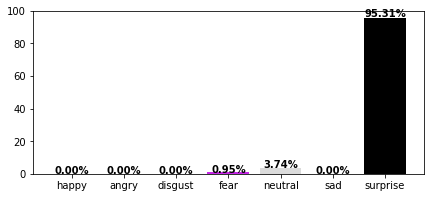

>> 지금 놀라 보입니다.


하고싶은 말을 입력해주세요 : 오늘 날씨 진짜 조아 그칭


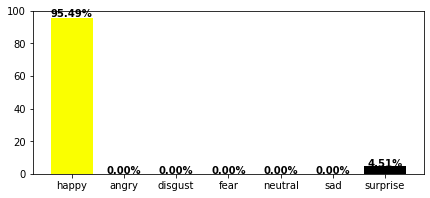

>> 지금 행복해 보입니다.


하고싶은 말을 입력해주세요 : 나는 바퀴벌레가 진짜 무서워...


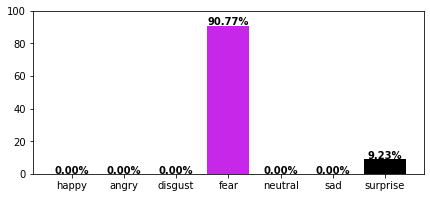

>> 지금 공포스러워 보입니다.


하고싶은 말을 입력해주세요 : 코로나는 대체 언제 끝날까..


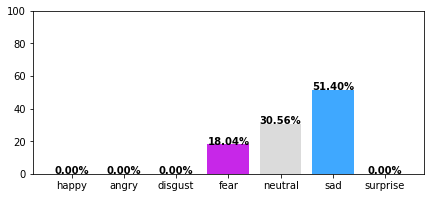

>> 지금 슬퍼 보입니다.


하고싶은 말을 입력해주세요 : 나 마스크 쓰는 거 너무 답답해


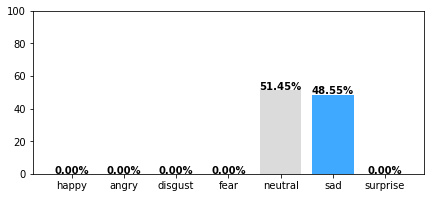

>> 지금 아무 감정을 느끼지 않는 걸로 보입니다.


하고싶은 말을 입력해주세요 : 나 마스크 쓰는 거 진짜 짜증나!!!!!!


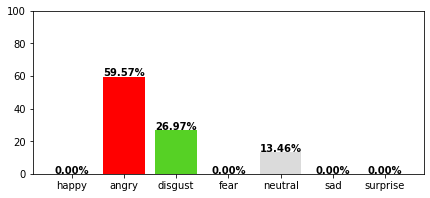

>> 지금 화나 보입니다.


하고싶은 말을 입력해주세요 : 0


In [101]:
# 질문 테스트. 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")